# 2010RF12 close approaches prediction
Written by Jackey Fang<br>
<br>
**Last Update**<br>
2026-02-25|

# Imports

In [240]:
import requests
import numpy as np
import rebound
import warnings
import matplotlib.pyplot as plt
import os
import contextlib
import pyarrow.parquet as pq
from astropy.time import Time
from erfa.core import ErfaWarning

# API and Data Extraction

In [241]:
def fetch_data(asteroid_id):
    """
    Get orbital elements and covariance matrix of asteroid from each agencies
    """
    print(f"Fetching Data for {asteroid_id}")

    # NASA SBDB API
    nasa_url = f"https://ssd-api.jpl.nasa.gov/sbdb.api?sstr={asteroid_id}&cov=mat&full-prec=true"
    print("Fetching from NASA SBDB...")
    nasa_req = requests.get(nasa_url)
   
    if nasa_req.status_code == 200:
        nasa_data = nasa_req.json()
       
    # Grab the labels
        nasa_labels = nasa_data['orbit']['covariance']['labels'][:6]
       
        # Covariance Matrix
        nasa_covariance = np.array(nasa_data['orbit']['covariance']['data'], dtype=float)
        nasa_covariance_6 = nasa_covariance[:6, :6]

        # Build dict
        elements_list = nasa_data['orbit']['elements']
        elements_dict = {item['name']: float(item['value']) for item in elements_list}

        # Key map
        name_map = {'node': 'om', 'peri': 'w'}
        nasa_elements = []

        for label in nasa_labels:
            # Get the correct lookup key
            lookup_key = name_map.get(label, label)
            nasa_elements.append(elements_dict[lookup_key])

        nasa_elements = np.array(nasa_elements, dtype=float)
        nasa_epoch_jd = float(nasa_data['orbit']['epoch'])
        print(f"NASA Data Retrieved in format: {nasa_labels}")

    else:
        print("NASA fetch failed.")
        return None, None, None, None, None, None, None, None

    # ESA NEO API
    esa_id = asteroid_id.replace(" ", "")
    esa_url = f"https://neo.ssa.esa.int/PSDB-portlet/download?file={esa_id}.eq0"
    print("\nFetching from ESA NEO Portal...")
    esa_req = requests.get(esa_url)

    if esa_req.status_code == 200 and "END_OF_HEADER" in esa_req.text:
        esa_covariance = []
        esa_elements = []
        esa_labels = ['a', 'e', 'i', 'om', 'w', 'ma']

        for line in esa_req.text.splitlines():
            clean_line = line.strip()
            if clean_line.startswith('MJD'):
                mjd = float(clean_line.split()[1])
                esa_epoch_jd = mjd + 2400000.5

            elif clean_line.startswith('KEP'):
                esa_elements = np.array([float(x) for x in clean_line.split()[1:7]])

            elif clean_line.startswith('EQU'):
                esa_elements = np.array([float(x) for x in clean_line.split()[1:7]])
                esa_labels = ['a', 'h', 'k', 'p', 'q', 'lon']

            elif clean_line.startswith('COV'):
                esa_covariance.extend([float(x) for x in clean_line.split()[1:]])

        # Reconstruct the matrix
        esa_covariance_6 = np.zeros((6, 6))
        idx = 0
        for i in range(6):
            for j in range(i + 1):
                esa_covariance_6[i, j] = esa_covariance[idx]
                esa_covariance_6[j, i] = esa_covariance[idx]
                idx += 1
               
        print(f"ESA Data Retrieved in format: {esa_labels}")

    else:
        print("ESA fetch failed.")
        return nasa_elements, nasa_covariance_6, nasa_labels, nasa_epoch_jd, None, None, None, None

    return nasa_elements, nasa_covariance_6, nasa_labels, nasa_epoch_jd, esa_elements, esa_covariance_6, esa_labels, esa_epoch_jd

In [242]:
asteroid = "2010 RF12"
nasa_ele, nasa_cov, nasa_lbl, nasa_epoch, esa_ele, esa_cov, esa_lbl, esa_epoch = fetch_data(asteroid)

Fetching Data for 2010 RF12
Fetching from NASA SBDB...
NASA Data Retrieved in format: ['e', 'q', 'tp', 'node', 'peri', 'i']

Fetching from ESA NEO Portal...
ESA Data Retrieved in format: ['a', 'h', 'k', 'p', 'q', 'lon']


# Virtual Asteroids

In [243]:
def generate_virtual_asteroids(orb_elements, covariance_matrix, num_samples=1000):
    """
    Spawns virtual asteroids based on orbital uncertainty.
    """

    virtual_asteroids = np.random.multivariate_normal(
        mean = orb_elements, 
        cov = covariance_matrix, 
        size = num_samples
    )

    virtual_asteroids[0] = orb_elements
    
    return virtual_asteroids

In [244]:
num_asteroids = 100

# Spawn NASA
nasa_vas = generate_virtual_asteroids(nasa_ele, nasa_cov, num_asteroids)

# Spawn ESA
esa_vas = generate_virtual_asteroids(esa_ele, esa_cov, num_asteroids)

# Convert to cartesian coordinates

In [245]:
def translate_to_cartesian(vas_matrix, labels, native_epoch_jd):
    """
    Translates orbital elements to Barycentric coordinates 
    at their epoch
    """
    print(f"Translating {len(vas_matrix)} asteroids at native JD {native_epoch_jd}...")
    cartesian_matrix = np.zeros((len(vas_matrix), 6))
    
    sim = rebound.Simulation()
    sim.units = ('AU', 'days', 'Msun')
    
    with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
        sim.add("Sun", date=f"JD {native_epoch_jd}")
    
    k_gauss = 0.01720209895

    for i in range(len(vas_matrix)):
        row = vas_matrix[i]
        data = {labels[j]: row[j] for j in range(6)}
        
        try:
            # NASA cometary translation
            if 'q' in labels and 'tp' in labels:
                e = data['e']
                q = data['q']
                
                a = q / (1.0 - e) if e < 1.0 else q 
                inc = np.radians(data['i'])
                Omega = np.radians(data['node'])
                omega = np.radians(data['peri'])
                
                n = k_gauss / (a**1.5)
                m_native = n * (native_epoch_jd - data['tp'])
                m_native = m_native % (2 * np.pi)

            # ESA equinoctial translation
            elif 'h' in labels and 'k' in labels:
                a, h, k = data['a'], data['h'], data['k']
                p, q_eq = data['p'], data['q'] 
                lon = np.radians(data['lon'])
                
                e = np.sqrt(h**2 + k**2)
                inc = 2 * np.arctan(np.sqrt(p**2 + q_eq**2))
                Omega = np.arctan2(p, q_eq) if (p!=0 or q_eq!=0) else 0.0
                omega = np.arctan2(h, k) - Omega if (h!=0 or k!=0) else 0.0

                m_native = lon - omega - Omega
                m_native = m_native % (2 * np.pi)

            # ESA standard keplerian
            else:
                a = data['a']
                e = data['e']
                inc = np.radians(data['i'])
                Omega = np.radians(data['om'])
                omega = np.radians(data['w'])
                m_native = np.radians(data['ma'])

            # Add the Virtual Asteroid to the REBOUND simulation at the native epoch
            sim.add(a=a, e=e, inc=inc, Omega=Omega, omega=omega, M=m_native, primary=sim.particles[0])
            
            p_cart = sim.particles[1]
            cartesian_matrix[i] = [p_cart.x, p_cart.y, p_cart.z, p_cart.vx, p_cart.vy, p_cart.vz]
            sim.remove(index=1)
            
        except Exception as e:
            pass
            
    print("Translation complete.")
    return cartesian_matrix

In [246]:
nasa_cartesian = translate_to_cartesian(nasa_vas, nasa_lbl, nasa_epoch)
esa_cartesian = translate_to_cartesian(esa_vas, esa_lbl, esa_epoch)

Translating 100 asteroids at native JD 2461000.5...
Translation complete.
Translating 100 asteroids at native JD 2459007.002212329...
Translation complete.


# N body sim

In [247]:
def nbody_simulation(cartesian_matrix, start_jd, impact_date_utc, is_heliocentric=False):
    """
    Flies a cloud of asteroids forward in time and maps them onto the Earth's Target Plane.
    """
    # Convert the Impact Date to a Julian Date
    tca_time = Time(impact_date_utc, format='isot', scale='tdb')
    impact_jd = tca_time.jd 
    
    # Set up the Solar System
    sim = rebound.Simulation()
    sim.units = ('AU', 'days', 'Msun')
    sim.t = start_jd
    
    # Add the gravitational heavyweights
    with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
        sim.add("Sun", date=f"JD {start_jd}")
        sim.add("199", date=f"JD {start_jd}") # Mercury
        sim.add("299", date=f"JD {start_jd}") # Venus
        sim.add("399", date=f"JD {start_jd}") # Earth
        sim.add("301", date=f"JD {start_jd}") # Moon
        sim.add("499", date=f"JD {start_jd}") # Mars
        sim.add("5", date=f"JD {start_jd}")   # Jupiter Barycenter
        sim.add("6", date=f"JD {start_jd}")   # Saturn Barycenter
        sim.add("7", date=f"JD {start_jd}")   # Uranus Barycenter
        sim.add("8", date=f"JD {start_jd}")   # Neptune Barycenter
    
    earth_idx = 3
    nominal_ast_idx = 10
    sun = sim.particles[0]
    sx, sy, sz = sun.x, sun.y, sun.z
    svx, svy, svz = sun.vx, sun.vy, sun.vz

    # Load nominal asteroid
    nominal_cart = cartesian_matrix[0]
    if is_heliocentric:
        sim.add(x=nominal_cart[0] + sx, y=nominal_cart[1] + sy, z=nominal_cart[2] + sz, 
                vx=nominal_cart[3] + svx, vy=nominal_cart[4] + svy, vz=nominal_cart[5] + svz, 
                m=0.0)
    else:
        sim.add(x=nominal_cart[0], y=nominal_cart[1], z=nominal_cart[2], 
                vx=nominal_cart[3], vy=nominal_cart[4], vz=nominal_cart[5], 
                m=0.0)
        
    nominal_ast_idx = 10
    
    # Load the Virtual Asteroids as massless
    for cart in cartesian_matrix[1:]:
        if is_heliocentric:
            sim.add(x=cart[0] + sx, y=cart[1] + sy, z=cart[2] + sz, 
                    vx=cart[3] + svx, vy=cart[4] + svy, vz=cart[5] + svz, 
                    m=0.0)
        else:
            sim.add(x=cart[0], y=cart[1], z=cart[2], 
                    vx=cart[3], vy=cart[4], vz=cart[5], 
                    m=0.0)
        
    # Fast forward
    sim.integrate(impact_jd)

    # Calculate the Target Plane
    earth = sim.particles[earth_idx]
    nom_ast = sim.particles[nominal_ast_idx]
    
    # Define the angle of the incoming cloud
    v_rel = np.array([nom_ast.vx - earth.vx, nom_ast.vy - earth.vy, nom_ast.vz - earth.vz])
    v_norm = v_rel / np.linalg.norm(v_rel) # The Eta axis (direction of travel)
    
    # Define the 2D cross-section axes
    k_hat = np.array([0, 0, 1])
    xi_dir = np.cross(v_norm, k_hat)
    xi_dir = xi_dir / np.linalg.norm(xi_dir)
    zeta_dir = np.cross(xi_dir, v_norm)
    
    # Map all asteroids onto the 2D plane
    b_plane_coords = np.zeros((len(cartesian_matrix), 2))
    AU_TO_EARTH_RADII = 23454.8 # Conversion factor

    # Map the nominal asteroid
    r_rel_nom = np.array([nom_ast.x - earth.x, nom_ast.y - earth.y, nom_ast.z - earth.z])
    xi_nom = np.dot(r_rel_nom, xi_dir) * AU_TO_EARTH_RADII
    zeta_nom = np.dot(r_rel_nom, zeta_dir) * AU_TO_EARTH_RADII
    b_plane_coords[0] = [xi_nom, zeta_nom]
    
    for i in range(1, len(cartesian_matrix)):
        ast = sim.particles[i + nominal_ast_idx] 
        r_rel = np.array([ast.x - earth.x, ast.y - earth.y, ast.z - earth.z])
        
        xi = np.dot(r_rel, xi_dir) * AU_TO_EARTH_RADII
        zeta = np.dot(r_rel, zeta_dir) * AU_TO_EARTH_RADII
        b_plane_coords[i] = [xi, zeta]

    warnings.simplefilter('ignore', category=ErfaWarning)

    return b_plane_coords

In [248]:
impact_date = "2095-09-05T23:45:36"

# NASA 
nasa_target_plane = nbody_simulation(nasa_cartesian, nasa_epoch, impact_date)

# ESA 
esa_target_plane = nbody_simulation(esa_cartesian, esa_epoch, impact_date)

# Plot

In [249]:
def plot_target_plane(nasa_bplane, esa_bplane):
    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    # Plot NASA Cloud (Blue)
    plt.scatter(nasa_bplane[:, 0], nasa_bplane[:, 1], 
                s=10, alpha=0.5, color='royalblue', label='NASA')

    # Plot ESA Cloud (Orange)
    plt.scatter(esa_bplane[:, 0], esa_bplane[:, 1], 
                s=10, alpha=0.5, color='darkorange', label='ESA')
    
    # Medians calc
    nasa_median_xi = np.nanmedian(nasa_bplane[:, 0])
    
    esa_median_xi = np.nanmedian(esa_bplane[:, 0])

    # NASA Median
    plt.axvline(nasa_median_xi, color='blue', linestyle=':', linewidth=1.5, label='NASA Median')
    
    # ESA Median
    plt.axvline(esa_median_xi, color='red', linestyle=':', linewidth=1.5, label='ESA Median')
    
    # Draw the Earth to scale at (0,0)
    earth = plt.Circle((0, 0), 1.0, color='mediumseagreen', alpha=0.8, label='Earth')
    ax.add_patch(earth)

    # Find the maximum distance in any direction across both clouds
    all_data = np.vstack((nasa_bplane, esa_bplane))
    max_limit = np.max(np.abs(all_data)) * 1.1 # Add 10% visual padding
    
    max_limit = max(max_limit, 5.0) 
    #max_limit = 15000

    ax.set_xlim(-max_limit, max_limit)
    ax.set_ylim(-max_limit, max_limit)

    # Formatting
    plt.axhline(0, color='gray', linestyle='-', linewidth=0.5)
    plt.axvline(0, color='gray', linestyle='-', linewidth=0.5)
    
    plt.xlabel(r'$\xi$ (Earth Radii)')
    plt.ylabel(r'$\zeta$ (Earth Radii)')
    plt.title('Target Plane of Close Approaches - 2010 RF12')
    
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(loc='upper right')
    
    ax.set_aspect('equal', adjustable='box') 

    plt.tight_layout()
    plt.show()

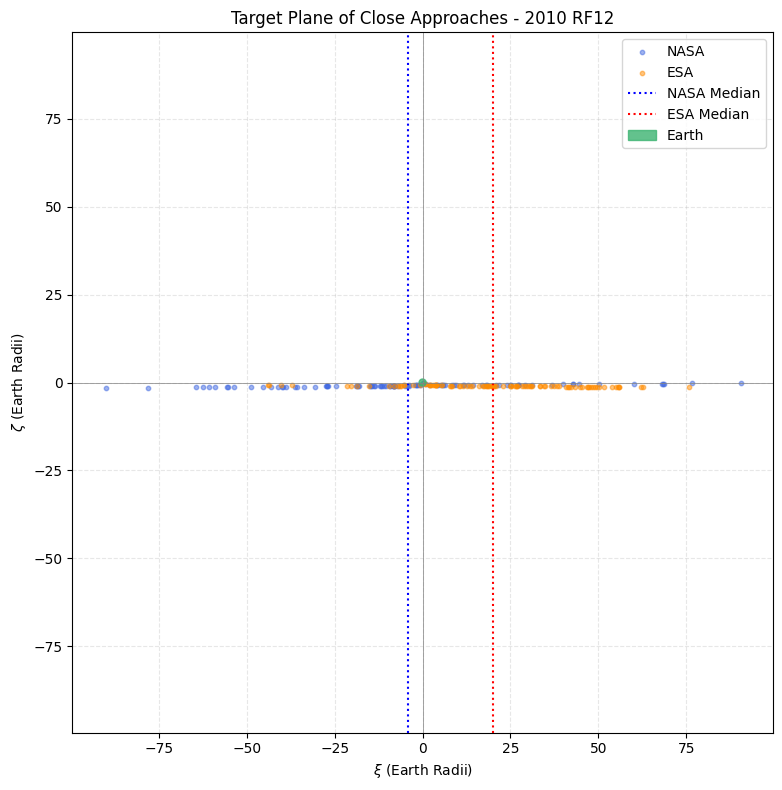

In [250]:
plot_target_plane(nasa_target_plane, esa_target_plane)

# Plot Zoom in

In [251]:
def plot_target_plane_limit(nasa_bplane, esa_bplane, x_max, x_min, y_max, y_min):
    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    # Plot NASA cloud
    plt.scatter(nasa_bplane[:, 0], nasa_bplane[:, 1], 
                s=10, alpha=0.5, color='royalblue', label='NASA')

    # Plot ESA cloud
    plt.scatter(esa_bplane[:, 0], esa_bplane[:, 1], 
                s=10, alpha=0.5, color='darkorange', label='ESA')
    
    # Medians calc
    nasa_median_xi = np.nanmedian(nasa_bplane[:, 0])
    
    esa_median_xi = np.nanmedian(esa_bplane[:, 0])

    # NASA Median
    plt.axvline(nasa_median_xi, color='blue', linestyle=':', linewidth=1.5, label='NASA Median')
    
    # ESA Median
    plt.axvline(esa_median_xi, color='red', linestyle=':', linewidth=1.5, label='ESA Median')

    # Draw the Earth to scale at (0,0)
    earth = plt.Circle((0, 0), 1.0, color='mediumseagreen', alpha=0.8, label='Earth')
    ax.add_patch(earth)

    # Set limits
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Formatting
    plt.axhline(0, color='gray', linestyle='-', linewidth=0.5)
    plt.axvline(0, color='gray', linestyle='-', linewidth=0.5)
    
    plt.xlabel(r'$\xi$ (Earth Radii)')
    plt.ylabel(r'$\zeta$ (Earth Radii)')
    plt.title('Target Plane of Close Approaches - 2010 RF12')
    
    plt.grid(True, alpha=0.3, linestyle='--')
    
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=9)
    ax.set_aspect('equal', adjustable='box')
    
    ax.set_aspect('equal', adjustable='box') 

    plt.tight_layout()
    plt.show()

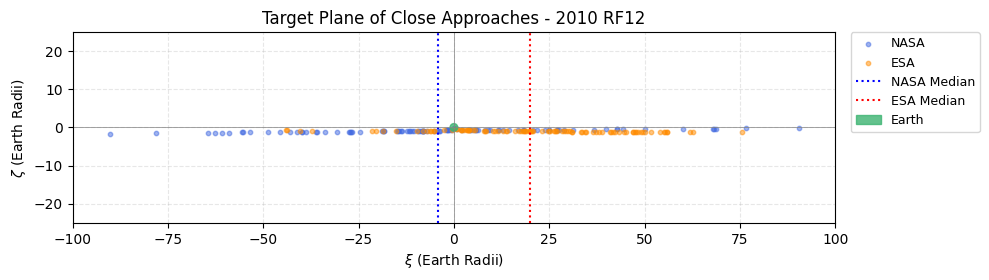

In [252]:
plot_target_plane_limit(nasa_target_plane, esa_target_plane, 100, -100, 25, -25)

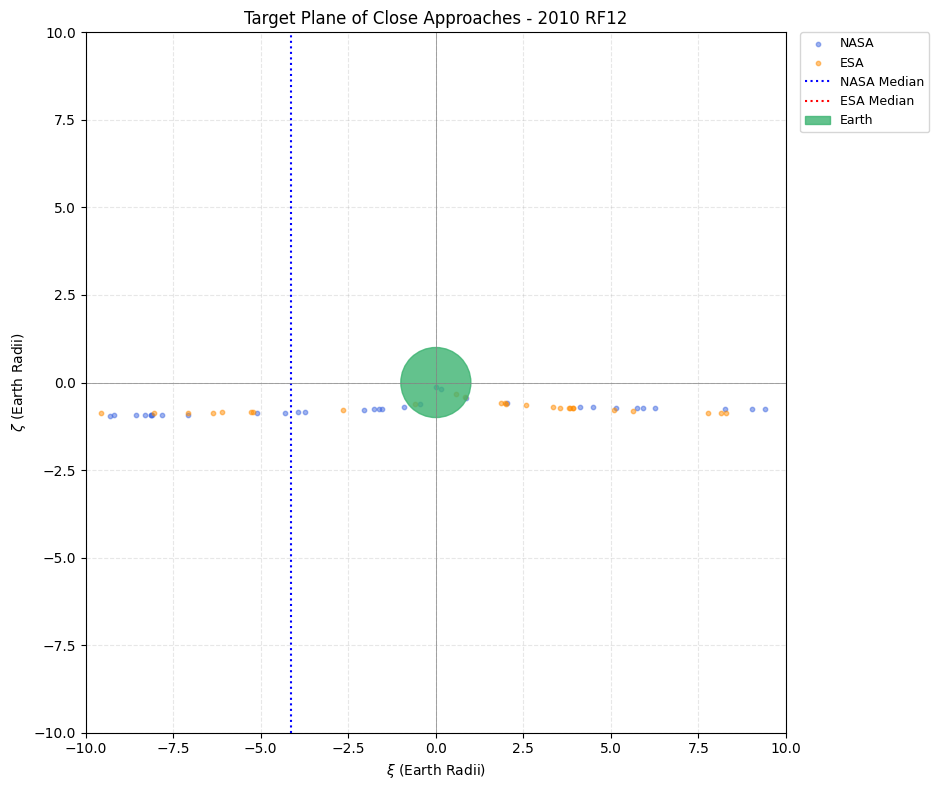

In [253]:
plot_target_plane_limit(nasa_target_plane, esa_target_plane, 10, -10, 10, -10)

# Impact Probabilities

In [254]:
def compute_impact_probability(bplane_data, num_asteroids):
    # distance from origin
    radial_distances = np.sqrt(bplane_data[:, 0]**2 + bplane_data[:, 1]**2)
    
    # Count how many dots fall within 1 R_earth
    impact_count = np.sum(radial_distances <= 1.0)
    
    # Compute the probability
    impact_probability = (impact_count / num_asteroids) * 100
    
    return impact_count, impact_probability

In [255]:
num_generated = 1000 

nasa_impacts, nasa_ip = compute_impact_probability(nasa_target_plane, num_generated)
esa_impacts, esa_ip = compute_impact_probability(esa_target_plane, num_generated)

print(f"NASA: {nasa_impacts} impacts out of {num_generated} ({nasa_ip:.2f}%)")
print(f"ESA:  {esa_impacts} impacts out of {num_generated} ({esa_ip:.2f}%)")

NASA: 4 impacts out of 1000 (0.40%)
ESA:  3 impacts out of 1000 (0.30%)


# With B612

In [256]:
def load_b612_virtual_asteroids(parquet_file, num_asteroids=1000):
    """
    Reads the B612 ADAM orbital elements, covariance, and epoch 
    using PyArrow.
    """

    # Read in
    table = pq.read_table(parquet_file)
    coords_dict = table.column('coordinates')[0].as_py()
    
    # Epoch
    time_data = coords_dict['time']
    days = float(time_data['days'])
    nanos = float(time_data['nanos'])
    
    mjd = days + (nanos / 8.64e13)
    b612_native_jd = mjd + 2400000.5
        
    # Conversion
    nominal_state = np.array([
        coords_dict['x'], 
        coords_dict['y'], 
        coords_dict['z'], 
        coords_dict['vx'], 
        coords_dict['vy'], 
        coords_dict['vz']
    ], dtype=float)

    cov_data = coords_dict['covariance']
    if isinstance(cov_data, dict) and 'values' in cov_data:
        cov_flat = cov_data['values']
    else:
        cov_flat = cov_data

    covariance_matrix = np.array(cov_flat, dtype=float).reshape((6, 6))

    b612_cartesian = np.random.multivariate_normal(nominal_state, covariance_matrix, num_asteroids)
    
    # First row to be the nominal
    b612_cartesian[0] = nominal_state
    
    return b612_native_jd, b612_cartesian

In [257]:
b612_file = 'data/initial_orbit.parquet'
num_asteroids = 100

b612_native_jd, b612_cartesian_ecliptic = load_b612_virtual_asteroids(b612_file, num_asteroids)
b612_target_plane = nbody_simulation(b612_cartesian_ecliptic, b612_native_jd, impact_date, is_heliocentric=True)

b612_impacts, esa_ip = compute_impact_probability(b612_target_plane, num_asteroids)
print(f"ESA: {b612_impacts} impacts out of {num_asteroids} ({esa_ip:.2f}%)")

ESA: 0 impacts out of 100 (0.00%)


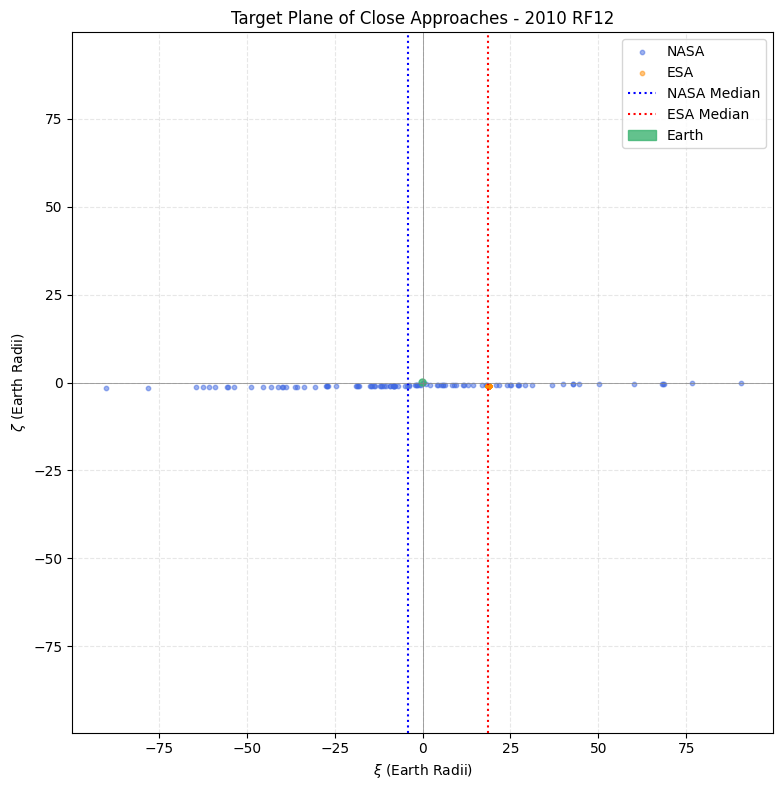

In [258]:
plot_target_plane(nasa_target_plane, b612_target_plane)

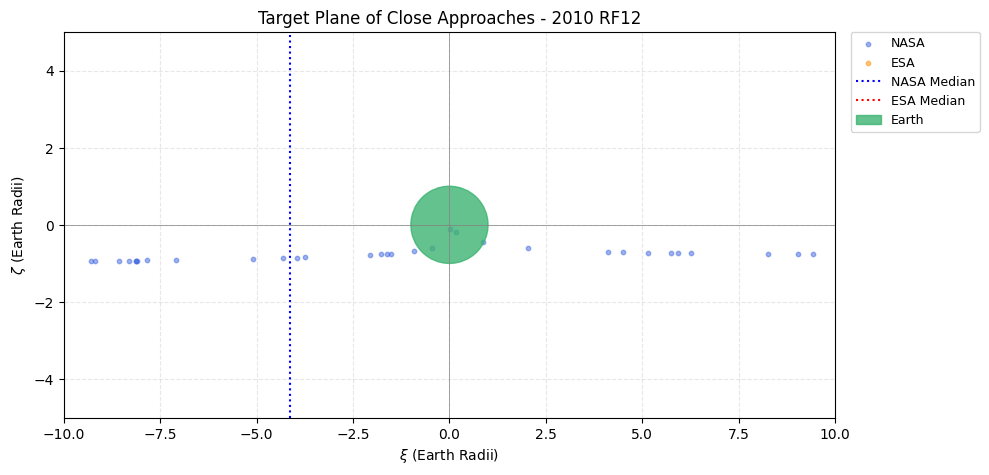

In [259]:
plot_target_plane_limit(nasa_target_plane, b612_target_plane, 10, -10, 5, -5)

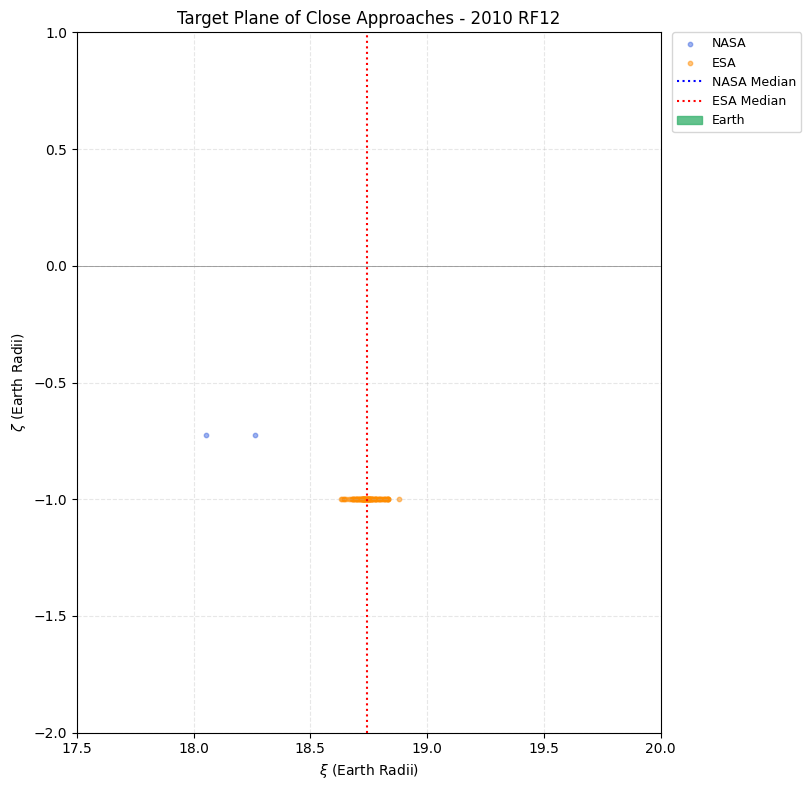

In [260]:
plot_target_plane_limit(nasa_target_plane, b612_target_plane, 20, 17.5, 1, -2)